## **1. Base model**

- The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. 

- We will use k=10, meaning each fold will contain about 130875/10 or 130872 examples.

- Each fold will contain the same mixture of examples by class, that is about 99.8 percent to 0.2 percent negative and positive transactions respectively.

In [12]:
import pandas as pd

df = pd.read_csv('dse_training_data_important_features.csv')
X = df.drop(columns=['converted_label'])
y = df['converted_label']
X.head()

,days_inactive,num_visits,sum_transactionRevenue,hits,pageviews,timeOnSite,timeOnSite_hours,timeOnSite_minutes,is_Northern America
0,0.626667,0.000000,0.0,0.001849,0.006768,0.020944,0.0,0.019126,0
1,0.626667,0.000000,0.0,0.001849,0.006768,0.010313,0.0,0.008197,0
2,0.626667,0.000000,0.0,0.005548,0.011280,0.002362,0.0,0.000000,0
3,0.626667,0.046286,0.0,0.009246,0.015793,0.006542,0.0,0.005464,1
4,0.626667,0.000000,0.0,0.009246,0.011280,0.003907,0.0,0.002732,0


In [2]:
len(X)

130875

In [3]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer


# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
	p, r, _ = precision_recall_curve(y_true, probas_pred)
	return auc(r, p)
 

# evaluate a model
def evaluate_model(X, y, model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	metric = make_scorer(pr_auc, needs_proba=True)
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

We will evaluate the following base machine learning models on the dataset:

    Decision Tree (CART)
    k-Nearest Neighbors (KNN)
    Bagged Decision Trees (BAG)
    Random Forest (RF)
    Extra Trees (ET)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier





# define models to test
def get_models():
	models, names = list(), list()

	# models.append(SVC())
	# names.append('SVC')
	
	models.append(LogisticRegression())
	names.append('LogisticRegression')

	models.append(DecisionTreeClassifier())
	names.append('CART')

	# steps = [('m',KNeighborsClassifier())]
	# #models.append(Pipeline(steps=steps))
	# models.append(KNeighborsClassifier())
	# names.append('KNN')

	models.append(XGBClassifier())
	names.append('XGBClassifier')

	models.append(BaggingClassifier(n_estimators=100))
	names.append('BAG')

	models.append(RandomForestClassifier(n_estimators=100))
	names.append('RF')

	models.append(ExtraTreesClassifier(n_estimators=100))
	names.append('ET')
	return models, names

>LogisticRegression 0.319 (0.088)
>CART 0.384 (0.079)
>XGBClassifier 0.432 (0.094)
>BAG 0.437 (0.093)
>RF 0.437 (0.094)
>ET 0.368 (0.091)


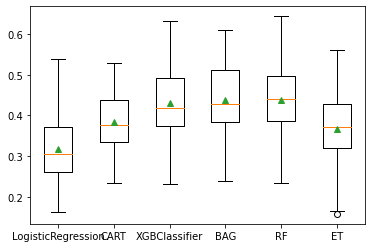

In [11]:
import numpy as np
import matplotlib.pyplot as plt
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
	scores = evaluate_model(X, y, models[i])
	results.append(scores)

	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

All of the tested algorithms have skill, achieving a PR AUC BELOW the default of 0.5, which means there is not much learning.

## **Sampling**

- Lets over sample the minority class (label 1) and over sample the majority (label 0).

In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


over = SMOTE(sampling_strategy=0.03)
under = RandomUnderSampler(sampling_strategy='majority')

X_over, y_over = over.fit_resample(X,y)

X_sampled, y_sampled = under.fit_resample(X_over, y_over)

In [28]:
len(X_over), len(y_over), len(X_sampled), len(y_sampled)

(134570, 134570, 7838, 7838)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.20, random_state=42)

>LogisticRegression 0.935 (0.010)
>CART 0.962 (0.007)
>XGBClassifier 0.996 (0.001)
>BAG 0.994 (0.003)
>RF 0.995 (0.002)
>ET 0.993 (0.003)


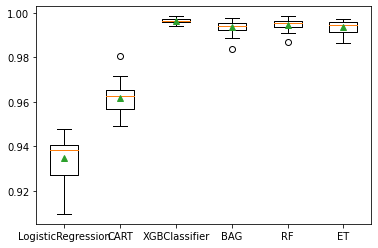

In [34]:
import numpy as np
import matplotlib.pyplot as plt

models_after_sample, names_after_sample = get_models()
results_after_sample = list()

# evaluate each model
for i in range(len(models_after_sample)):
	scores_after_sample = evaluate_model(X_train, y_train, models_after_sample[i])
	results_after_sample.append(scores_after_sample)

	print('>%s %.3f (%.3f)' % (names_after_sample[i], np.mean(scores_after_sample), np.std(scores_after_sample)))

plt.boxplot(results_after_sample, labels=names_after_sample, showmeans=True)
plt.show()

Model results have greatly improved after the sampling.

Lets evaluate on test data

In [57]:
predictions = []
for model in models_after_sample:
    pipeline = Pipeline(steps=[('m',model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions.append(y_pred)



C:\Users\Sahil\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


for i, prediction in enumerate(predictions):
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=prediction).ravel()
    precision, recall, _, _= precision_recall_fscore_support(y_true=y_test.tolist(), y_pred=list(prediction), average=None)
    print(f"For model {names_after_sample[i]}   tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp}, precision:{precision[1]}, recall:{recall[1]}")
    # print(prediction)
    # break


For model LogisticRegression   tn:652, fp:146, fn:71, tp:699, precision:0.8272189349112427, recall:0.9077922077922078
For model CART   tn:738, fp:60, fn:27, tp:743, precision:0.925280199252802, recall:0.964935064935065
For model XGBClassifier   tn:776, fp:22, fn:11, tp:759, precision:0.971830985915493, recall:0.9857142857142858
For model BAG   tn:767, fp:31, fn:15, tp:755, precision:0.960559796437659, recall:0.9805194805194806
For model RF   tn:766, fp:32, fn:10, tp:760, precision:0.9595959595959596, recall:0.987012987012987
For model ET   tn:757, fp:41, fn:12, tp:758, precision:0.9486858573216521, recall:0.9844155844155844


XGBClassifier so far has the best results.

In [81]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions[2]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       798
           1       0.97      0.99      0.98       770

    accuracy                           0.98      1568
   macro avg       0.98      0.98      0.98      1568
weighted avg       0.98      0.98      0.98      1568

